In [3]:
import random
import numpy as np
from typing import Optional, Tuple, Union, List

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms as T

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(False)

torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.matmul.allow_tf32 = True

torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.autograd.set_detect_anomaly(False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)



cpu


/home/zxc/.local/lib/python3.13/site-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [4]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def check_numel(module: torch.nn.Module, params_numel: int, buffers_numel: Optional[int] = None) -> None:
    """Check whether module has correct number of parameters and buffers
    :param torch.nn.Module module: Target model
    :param int params_numel: Target number of parameters
    :param Optional[int] buffers_numel: Target number of buffers
    :rtype:
    """
    numel = sum(param.numel() for param in module.parameters())
    assert numel == params_numel, f'For params numel != correct numel: {numel} vs {params_numel}'
    
    if buffers_numel is not None:
        numel = sum(param.numel() for param in module.buffers())
        assert numel == buffers_numel, f'For buffers numel != correct numel: {numel} vs {buffers_numel}'

set_global_seed(17)

In [5]:


def load_cifar(train, transform=None):    
    if transform is None:
        transform = T.ToTensor()
    return torchvision.datasets.CIFAR10(
        root='./data',
        train=train,
        transform=transform,
        download=True
    )



In [6]:

# YOUR CODE HERE
train_data = load_cifar(True, T.ToTensor())

print(train_data[0][0].size()) # размеры тензора

IMAGE_DIMENSION = 32
CHANNEL_NUM = 3

print(train_data[0][0])

images = torch.cat([tensor for tensor, ans in train_data])
answers = [ans for tensor, ans in train_data]

mean = images.mean().item()
std = images.std().item()
print("MEAN, STD:", mean, std)


norm_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std)
])

train_cifar = load_cifar(True, norm_transform)
val_cifar = load_cifar(False, norm_transform)



torch.Size([3, 32, 32])
tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314, 

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 1000

train_cifar_loader = DataLoader(
    dataset=train_cifar,
    batch_size=BATCH_SIZE_TRAIN,
    shuffle=True,
    drop_last=True
)

val_cifar_loader = torch.utils.data.DataLoader(
    dataset=val_cifar,
    batch_size=BATCH_SIZE_TEST,
    shuffle=False,
    drop_last=False
)

DATASET_SIZE = len(train_data)
print("DATASET_SIZE:", DATASET_SIZE)

DATASET_SIZE: 50000


In [8]:
CIFAR10_LABELS_LIST = [
    'airplane', 
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


images, labels = next(iter(train_cifar_loader))
images.shape, labels.shape #насколько я понял здесь мы сделали магию с указателями - почему то от начала надо взять next чтобы получить начальный элемент
#просто проверяем что загрузилось корректно короче


(torch.Size([64, 3, 32, 32]), torch.Size([64]))

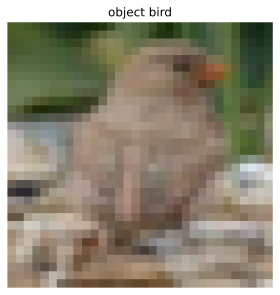

In [9]:

denorm_transform = T.Compose([
    T.Normalize(mean=[0, 0, 0], std=[1/std, 1/std, 1/std]),
    T.Normalize(mean=[-mean, -mean, -mean], std=[1, 1, 1])
])

i = 3
denormed_image = denorm_transform(images[i])

# Отображаем
plt.title(f'object {CIFAR10_LABELS_LIST[labels[i]]}')
plt.imshow(denormed_image.permute(1, 2, 0).numpy()) 
plt.axis('off')
plt.show()

In [10]:
def train_epoch(
    network,
    train_loader,
    criterion,
    optimizer,
    LOGGING_INTERVAL
) -> float:
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""
    
    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout
    id = 0
    TOTAL_DONE = 0
    TOTAL_LOSS = 0
    for images, answers in train_loader:
        id += 1
        # 0. распакавываем данные на нужное устройство
        images, answers = images.to(device), answers.to(device) # чего? кажется этот код смещает нагрузку на видеокарту но у меня встройка и линукс так что оно в моем случае ниче не делает

        # 1. сбрасываем градиенты предыдущего батча
        optimizer.zero_grad() # YOUR CODE HERE

        # 2. прогоняем данные через нашу нейросеть
        logits = network(images)

        # 3. считаем loss
        loss = criterion(logits, answers) # кажется так надо передавать reduction
        # 4. считаем градиенты
        loss.backward() # YOUR CODE HERE
        TOTAL_LOSS += loss.item()

        # 5. обновляем параметры
        optimizer.step() # YOUR CODE HERE

        TOTAL_DONE += answers.size(0)

        if (id % LOGGING_INTERVAL == 0):
            loss_num = loss.item()
            _, my_answers = torch.max(logits, 1)
            num_predicted = (my_answers == answers).sum().item()
            total = answers.size(0)

            print(id, "ITERATIONS", "[", TOTAL_DONE, '/', DATASET_SIZE, '(', TOTAL_DONE / DATASET_SIZE * 100, '%)]\t LOSS:', loss.item())
    return TOTAL_LOSS / id


In [11]:
#то же самое только тест

@torch.no_grad()
def val_epoch(
    network,
    val_loader,
    criterion
):
    """calculate loss and accuracy on validation data"""
    val_loss = 0
    correct = 0
    TOTAL_DONE = 0

    network.eval()  # switch network submodules to test mode
    for images, answers in val_loader:
        # 0. распакавываем данные на нужное устройство
        images, answers = images.to(device), answers.to(device) # YOUR CODE HERE

        # 1. прогоняем данные через нашу нейросеть
        logits = network(images) # YOUR CODE HERE

         # 2. получаем предсказание
        pred = torch.argmax(logits, dim=1) # YOUR CODE HERE

        # 3. логгируем лосс и accuracy
        val_loss += criterion(logits, answers).item()
        correct += torch.sum(pred == answers).item()

        TOTAL_DONE += answers.size(0)

    val_loss /= len(val_loader.dataset)
    val_accur = correct / len(val_loader.dataset)

    print(
        f'Test set: Avg. loss: {val_loss:.4f}',
        f'Accuracy: {correct}/{len(val_loader.dataset)}',
        f'({100. * val_accur:.0f}%)',
    )

    return val_loss, val_accur


In [12]:
import os
from torch.utils.tensorboard import SummaryWriter

def train_val(
    network,
    n_epochs,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    LOGGING_INTERVAL
):
    """full cycle of neural network training"""

    writer = SummaryWriter('runs/cifar')
    os.makedirs("models", exist_ok=True)

    best_acc = 0
    train_losses = []
    val_losses = []
    val_accs = []


    val_epoch(network, val_loader, criterion)
    for epoch in range(1, n_epochs + 1):
        avg_train_loss = train_epoch(network, train_loader, criterion, optimizer, LOGGING_INTERVAL)
        train_losses.append(avg_train_loss)
        
        val_loss, val_accuracy = val_epoch(network, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_accuracy)
        
        writer.add_scalar('Loss/train', avg_train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)


        if (val_accuracy > best_acc):
            best_acc = val_accuracy

            torch.save({
                'epoch': epoch,
                'model_state_dict': network.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_accuracy,
                'val_loss': val_loss,
            }, 'models/best.pth')

            print("NEW RECORD", best_acc * 100, '%')

            

    writer.close()
    
    checkpoint = torch.load('models/best.pth')
    network.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return train_losses, val_losses, val_accs


In [13]:


class LogReg(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten() # [X, 1, 28, 28] -> [X, 784] - преобразуемым данные в формат для линейной комбинации
        self.linear = nn.Linear(IMAGE_DIMENSION * IMAGE_DIMENSION * CHANNEL_NUM, len(CIFAR10_LABELS_LIST))

    def forward(self, x):
        
        x = self.flatten(x)

        return self.linear(x)



In [14]:

# создали нейронку
net = LogReg()


#тренируем

#выход нейронки - p_i = \sigma(out_i)

net = LogReg().to(device) # на GPU
criterion = nn.CrossEntropyLoss() # [LOSS_i = \sum_{i=0}^9{ln n_i * p_i - (1-n_i) * (1 - p_i)} - n_i = 1 если мы зашадали iую цифру
# берем такую функцию loss насколько я понял, чтобы там хорошие производные получались - ведь мы буквально берем производную по Loss чтобы найти где минимум ошибки
#out_i = bias_i + \sum{w_i * x_i} - w_i - вес, x_i - значение
#таким образом производные получатся:

#здесь будет вывод мб, пока не написал

# Оптимизатор - Stochastic Gradient Descent

print("BEGIN TRAINING")

#train_val(net, 10, criterion, train_cifar_loader, val_cifar_loader, 300)
print("training finished")

BEGIN TRAINING
training finished


In [15]:
# ! pip3 install tensorboard
from torch.utils.tensorboard import SummaryWriter


In [16]:
%load_ext tensorboard
%tensorboard --logdir .
#30 процентов - как то грустно - я загуглил какие другие простые модели существует - выдало что то про CNN, попробую реализовать

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [18]:
def train_cnn():
    model = CNN_net().to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    criterion = nn.CrossEntropyLoss()
    
    print("BEGIN CNN TRAINING")
    
    train_losses, val_losses, val_accs = train_val(
        model, 50, optimizer, criterion, train_cifar_loader, val_cifar_loader, 100
    )
    
    print("CNN training finished")
    return model, train_losses, val_losses, val_accs

cnn_model, train_loss, val_loss, val_acc = train_cnn()

BEGIN CNN TRAINING
Test set: Avg. loss: 0.0023 Accuracy: 961/10000 (10%)
100 ITERATIONS [ 6400 / 50000 ( 12.8 %)]	 LOSS: 1.772432565689087
200 ITERATIONS [ 12800 / 50000 ( 25.6 %)]	 LOSS: 1.3086721897125244
300 ITERATIONS [ 19200 / 50000 ( 38.4 %)]	 LOSS: 1.188489556312561
400 ITERATIONS [ 25600 / 50000 ( 51.2 %)]	 LOSS: 1.120774269104004
500 ITERATIONS [ 32000 / 50000 ( 64.0 %)]	 LOSS: 1.0719904899597168
600 ITERATIONS [ 38400 / 50000 ( 76.8 %)]	 LOSS: 1.1499156951904297
700 ITERATIONS [ 44800 / 50000 ( 89.60000000000001 %)]	 LOSS: 1.1077417135238647
Test set: Avg. loss: 0.0010 Accuracy: 6353/10000 (64%)
NEW RECORD 63.53 %
100 ITERATIONS [ 6400 / 50000 ( 12.8 %)]	 LOSS: 0.8492021560668945
200 ITERATIONS [ 12800 / 50000 ( 25.6 %)]	 LOSS: 0.920577883720398
300 ITERATIONS [ 19200 / 50000 ( 38.4 %)]	 LOSS: 0.7681818604469299
400 ITERATIONS [ 25600 / 50000 ( 51.2 %)]	 LOSS: 0.9012620449066162
500 ITERATIONS [ 32000 / 50000 ( 64.0 %)]	 LOSS: 1.2060264348983765
600 ITERATIONS [ 38400 / 50000

KeyboardInterrupt: 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir .